# Your Local GAN — Scribblings

In [218]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Why it matters
- Improves performance compared to SAGAN in terms of Frechet Inception Distance 

## Dense attention

In [3]:
class DenseAttention(tf.keras.models.Model):
    def __init__(self, dims):
        self.dense_key = tf.keras.layers.Dense(units=dims[0])
        self.dense_query = tf.keras.layers.Dense(units=dims[0])
        self.dense_value = tf.keras.layers.Dense(units=dims[1])
        
    def __call__(self, X, Y):
        """
        X: has shape (Nx, Ex)
        Y: has shape (Ny, Ey)
        """
        key = self.dense_key(X) # (Ex, E)
        query = self.dense_query(Y) # (Ey, E)
        value = self.dense_value(X) # (Ex, Ev)
        
        select = query @ tf.transpose(key) # (Ey, Ex)
        prob = tf.softmax(select)
        return prob @ value # (Ey, Ev)

## The query, key, value idea

This is a characterisation of the attention mechanism, where the `query` matrix contains a set of $E_Y$ "queries" in the form of $E$ dimensional vectors. The `key` matrix can be regarded a set of $E_X$. The `value` matrix contains $E_X$ values corresponding to the keys. 

When we query the value at a key in lookup table e.g. `lookup_table[key]` for a python dict we know which key we want to query. Here however we don't know what key we want to look-up. Instead we find a probability matrix $P = \text{softmax}(W_QW_K^T)$ where $P_{ab}, a \in [0, E_Y), b \in [0, E_X)$ indicates the probability that that key $b$ is relevant to query $a$.

Thus the lookup step leading to a single value is replaced by a weighted sum of the values, $P_aW_V$ for query $a$.

## Sparse attention

- Complexity for a query is quadratic since it needs dot products of each query to all the keys.
    - If there are $K$ keys and the query/key vector dimension is $E$, since each dot product has a complexity of $O(E)$ if $K = O(E)$ then the total complexity per query will be $O(E^2)$. 
- Instead separate attention heads are used where in each step a query attends only to a selected number of keys $K'<< E$ so the total complexity per query will be $O(E)$.
- The idea is that even though in one layer the elements of the output only attend to a few of the elements of the input, if the attention masks are "wired" properly, then information can flow from all elements of the input to all elements of the output 
- The formulation was not defined in this paper but based on the diagrams in the paper it looks like the following.


In [215]:
def get_first_mask(n, direction='ltr'):
    sqrt_n = tf.cast(tf.sqrt(tf.cast(n, tf.float32)), tf.int32)
    inds_base = tf.where(tf.linalg.band_part(tf.ones((sqrt_n, sqrt_n)), -1, 0))
    shifts = tf.cast(tf.range(start=0, limit=n, delta=sqrt_n)[:, None, None], inds_base.dtype)
    inds = shifts + inds_base[None]
    inds = tf.reshape(inds, [-1, 2])
    mask = tf.scatter_nd(indices=inds,
                         updates=tf.ones(tf.shape(inds)[0]), 
                         shape=[n, n])
    if direction == 'rtl':
        mask = tf.transpose(mask, (1, 0))
    return mask

def get_second_mask(n, direction='ltr'):
    sqrt_n = tf.cast(tf.sqrt(tf.cast(n, tf.float32)), tf.int32)
    base_block = tf.concat([tf.zeros([n, sqrt_n-1]), tf.ones([n, 1])], axis=-1)
    mask = tf.tile(base_block, [1, sqrt_n])
    if direction == 'rtl':
        mask = mask[:, ::-1]
    mask = tf.clip_by_value(mask + tf.eye(n), 0, 1)
    return mask

def get_masks(n, direction):
    assert direction in ['ltr', 'rtl']
    assert np.round(np.sqrt(n)) == np.sqrt(n), 'n must be a square number but is {}'.format(n)
    sqrt_n = tf.cast(tf.sqrt(tf.cast(n, tf.float32)), tf.int32)
    mask1 = get_first_mask(n, direction)
    mask2 = get_second_mask(n, direction)
    return mask1, mask2

In [216]:
def plot_mask(m, ax, title):
    ax.pcolor(m, edgecolors='white', linewidths=2, cmap='Reds')
    ax.invert_yaxis();
    ax.set_xticks(np.arange(16) + 0.5);
    ax.set_yticks(np.arange(16) + 0.5);
    ax.set_xticklabels(np.arange(16));
    ax.set_yticklabels(np.arange(16));
    ax.set_title(title);
    
def plot_masks(m1, m2, n, direction='ltr'):
    m1, m2 = get_masks(n, direction)
    m1 = m1.numpy()
    m2 = m2.numpy()
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    plot_mask(m1, axes[0], 'Step 0')
    plot_mask(m2, axes[1], 'Step 1')
    plot_mask(m1 + (m2 * 2), axes[2], 'Both steps')
    plt.suptitle('Masks for {} pattern'.format(direction.upper()), fontsize=16, fontweight='bold')

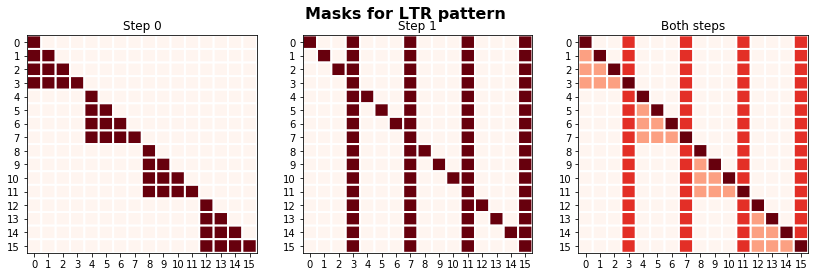

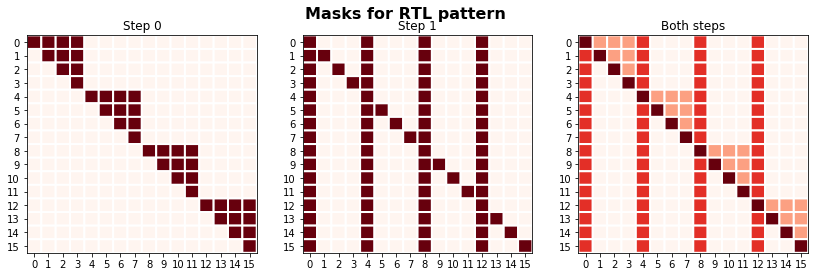

In [217]:
plot_masks(m1, m2, 16)
plot_masks(m1, m2, 16, 'rtl')

## Reduction in complexity
- If `mask[i,j]` is 1 then `pixel[i]` (of the output I think) attends to `pixel[j]` (of the input I think) 
- In the first mask, the lower or upper triangle part of a matrix of size $\sqrt{n}$ is replicated along the diagonal, so $\sqrt{n}$ matrices of size $O\left(\left(\sqrt{n}\right)^2\right) = O(n)$ so that the total number of active "paths" is $O\left(n \sqrt{n}\right) < O(n^2)$.
- In the second case every $\sqrt{n}$-th column is all ones plus all the diagonal entries and as there are $\sqrt{n}$ such columns each with $n$ elements, and there $n$ diagnonal elements, again there are $O\left(n \sqrt{n}\right) < O(n^2)$ active paths.

## Questions:
- Is my formulation the right one?
- How does it relate to attention mechanism in Sparse Transformer paper?
- Do the feature maps have to be square (like I have assumed) and if not how should the mechanism be modified?